In [1]:
# TRAIN
import numpy as np
import pickle
from spams import trainDL
from benchmarks.sparse.dict_train.patching import patch_pruning, rnd_smp_patch

# TEST
import numpy as np
from os import listdir, mkdir
from os.path import isdir
from skimage.io import imread, imsave
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage.transform import resize
from tqdm import tqdm
import pickle
from benchmarks.sparse.ScSR import ScSR
from benchmarks.sparse.backprojection import backprojection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

In [2]:
# ========================================================================
# Demo codes for dictionary training by joint sparse coding
#
# Reference
#   J. Yang et al. Image super-resolution as sparse representation of raw
#   image patches. CVPR 2008.
#   J. Yang et al. Image super-resolution via sparse representation. IEEE
#   Transactions on Image Processing, Vol 19, Issue 11, pp2861-2873, 2010
#
# Jianchao Yang
# ECE Department, University of Illinois at Urbana-Champaign
# For any questions, send email to jyang29@uiuc.edu
# =========================================================================
dict_size = 2048         # dictionary size
lmbd = 0.1          # sparsity regularization
patch_size = 3            # image patch size
nSmp = 100000       # number of patches to sample
upscale = 2            # upscaling factor

train_img_path = 'mock_data/train/'   # Set your training images dir

# Randomly sample image patches
Xh, Xl = rnd_smp_patch(train_img_path, patch_size, nSmp, upscale)

# Prune patches with small variances
Xh, Xl = patch_pruning(Xh, Xl)
Xh = np.asfortranarray(Xh)
Xl = np.asfortranarray(Xl)

# Dictionary learning
Dh = trainDL(Xh, K=dict_size, lambda1=lmbd, iter=100)
Dl = trainDL(Xl, K=dict_size, lambda1=lmbd, iter=100)

# Saving dictionaries to files
with open('benchmarks/sparse/data/dicts/' + 'Dh_' + str(dict_size) + '_US' + str(upscale) + '_L' + str(lmbd) + '_PS' + str(patch_size) + '.pkl', 'wb') as f:
    pickle.dump(Dh, f, pickle.HIGHEST_PROTOCOL)

with open('benchmarks/sparse/data/dicts/' + 'Dl_' + str(dict_size) + '_US' + str(upscale) + '_L' + str(lmbd) + '_PS' + str(patch_size) + '.pkl', 'wb') as f:
    pickle.dump(Dl, f, pickle.HIGHEST_PROTOCOL)


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'numpy.ndarray'>


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


num param iterD: 1
Online Dictionary Learning with no parameter 
mode Alpha 2
Cleaning activated 
batch size: 2304
L: 9
lambda: 0.1
mode: 2
*****Online Dictionary Learning*****
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iterati

Time elapsed : 33.9949
Time elapsed : 54.5042


In [3]:
def normalize_signal(img, channel):
    if np.mean(img[:, :, channel]) * 255 > np.mean(img_lr_ori[:, :, channel]):
        ratio = np.mean(img_lr_ori[:, :, channel]) / (np.mean(img[:, :, channel]) * 255)
        img[:, :, channel] = np.multiply(img[:, :, channel], ratio)
    elif np.mean(img[:, :, channel]) * 255 < np.mean(img_lr_ori[:, :, channel]):
        ratio = np.mean(img_lr_ori[:, :, channel]) / (np.mean(img[:, :, channel]) * 255)
        img[:, :, channel] = np.multiply(img[:, :, channel], ratio)
    return img[:, :, channel]


def normalize_max(img):
    for m in range(img.shape[0]):
        for n in range(img.shape[1]):
            if img[m, n, 0] > 1:
                img[m, n, 0] = 1
            if img[m, n, 1] > 1:
                img[m, n, 1] = 1
            if img[m, n, 2] > 1:
                img[m, n, 2] = 1
    return img

In [4]:
# Set which dictionary you want to use
D_size = 2048
US_mag = 2
lmbd = 0.1
patch_size = 3

dict_name = str(D_size) + '_US' + str(US_mag) + '_L' + str(lmbd) + '_PS' + str(patch_size)

with open('benchmarks/sparse/data/dicts/Dh_' + dict_name + '.pkl', 'rb') as f:
    Dh = pickle.load(f)
    Dh = normalize(Dh)

with open('benchmarks/sparse/data/dicts/Dl_' + dict_name + '.pkl', 'rb') as f:
    Dl = pickle.load(f)
    Dl = normalize(Dl)

In [35]:
from tifffile import imread, imsave

# SET PARAMETERS
img_lr_dir = 'data/val_lr/'
img_hr_dir = 'data/val_hr/'
img_dir = 'mock_data/train/'
overlap = 1
lmbd = 0.1
upscale = 3
maxIter = 100

###

img_lr_file = listdir(img_dir)

for i in tqdm(range(len(img_lr_file))):
    # Read test image
    img_name = img_lr_file[i]
    img_name_dir = list(img_name)
    img_name_dir = np.delete(np.delete(np.delete(np.delete(img_name_dir, -1), -1), -1), -1)
    img_name_dir = ''.join(img_name_dir)
    if isdir('mock_data/results/' + dict_name + '_' + img_name_dir) == False:
        new_dir = mkdir('{}{}'.format('mock_data/results/' + dict_name + '_', img_name_dir))
    
    img = imread('{}{}'.format(img_dir, img_name))
    img_lr = img[0][0].astype('double')

    # Read and save ground truth image
    img_hr = img[1][0].astype('double')
    imsave('{}{}{}{}'.format('mock_data/results/' + dict_name + '_', img_name_dir, '/', '3HR.png'), img_hr)
    # img_hr_y = rgb2ycbcr(img_hr)[:, :, 0]

    # Change color space
    img_lr_ori = img_lr
    temp = img_lr
    img_lr = rgb2ycbcr(img_lr)
    img_lr_y = img_lr[:, :, 0]
    img_lr_cb = img_lr[:, :, 1]
    img_lr_cr = img_lr[:, :, 2]

    # Upscale chrominance to color SR images
    img_sr_cb = resize(img_lr_cb, (img_hr.shape[0], img_hr.shape[1]), order=0)
    img_sr_cr = resize(img_lr_cr, (img_hr.shape[0], img_hr.shape[1]), order=0)

    # Super Resolution via Sparse Representation
    img_sr_y = ScSR(img_lr_y, img_hr_y.shape, upscale, Dh, Dl, lmbd, overlap)
    img_sr_y = backprojection(img_sr_y, img_lr_y, maxIter)

    # Create colored SR images
    img_sr = np.stack((img_sr_y, img_sr_cb, img_sr_cr), axis=2)
    img_sr = ycbcr2rgb(img_sr)

    # Signal normalization
    for channel in range(len(img_sr.shape[2])):
        img_sr[:, :, channel] = normalize_signal(img_sr, channel)

    # Maximum pixel intensity normalization
    img_sr = normalize_max(img_sr)

    # Bicubic interpolation for reference
    img_bc = resize(img_lr_ori, (img_hr.shape[0], img_hr.shape[1]))
    imsave('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', '1bicubic.png'), img_bc, quality=100)
    img_bc_y = rgb2ycbcr(img_bc)[:, :, 0]

    # Compute RMSE for the illuminance
    rmse_bc_hr = np.sqrt(mean_squared_error(img_hr_y, img_bc_y))
    rmse_bc_hr = np.zeros((1,)) + rmse_bc_hr
    rmse_sr_hr = np.sqrt(mean_squared_error(img_hr_y, img_sr_y))
    rmse_sr_hr = np.zeros((1,)) + rmse_sr_hr
    np.savetxt('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', 'RMSE_bicubic.txt'), rmse_bc_hr)
    np.savetxt('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', 'RMSE_SR.txt'), rmse_sr_hr)

    imsave('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', '2SR.png'), img_sr, quality=100)


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (66, 96)

In [43]:
img_sr_y = ScSR(img_lr, img_hr.shape, 4, Dh, Dl, lmbd, overlap)

100%|██████████| 47/47 [01:15<00:00,  1.60s/it]


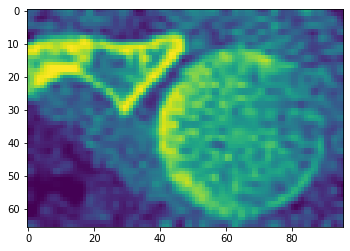

In [45]:

plt.imshow(img_lr)

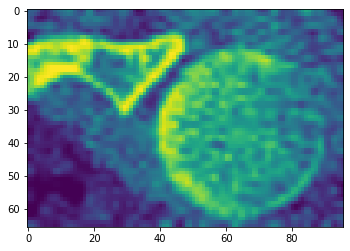

In [46]:

plt.imshow(img_sr_y)